<a href="https://colab.research.google.com/github/SSSpock/skillspire/blob/main/casestudy_2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install faker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.8 MB/s eta 0:00:00


In [94]:
## Users DF

import numpy as np
import pandas as pd
from faker import Faker
from datetime import datetime

# Initialize the Faker library
fake = Faker()

# Define the number of unique users
num_users = 100000

# Generate user_id
user_id = list(range(1, num_users + 1))

np.random.seed(100)
# Generate age
median_age = 25
ages = np.random.normal(loc=median_age, scale=5, size=num_users).astype(int)

# Generate gender
gender_ratio = [0.48, 0.5, 0.01, 0.01]  # Male, Female, Non-Binary, Prefer not to say
gender = np.random.choice(["Male", "Female", "Non-Binary", "Prefer not to say"], size=num_users, p=gender_ratio)

# Generate country
countries = ["United States", "United Kingdom", "France", "Germany", "Spain", "Italy", "Netherlands", "Belgium", "Sweden", "Norway", "Denmark", "Finland", "Switzerland", "Ireland", "Austria", "Portugal", "Greece"]
country = np.random.choice(countries, size=num_users)

# Generate signup_date
signup_dates = [fake.date_between(start_date='-3y', end_date='today') for _ in range(num_users)]

# Generate subscription_type
subscription_ratio = [0.6, 0.3, 0.1]  # Free, Basic, Premium
subscription_type = np.random.choice(["Free", "Basic", "Premium"], size=num_users, p=subscription_ratio)

# Create the Users DataFrame
users_df = pd.DataFrame({"user_id": user_id, "age": ages, "gender": gender, "country": country, "signup_date": signup_dates, "subscription_type": subscription_type})

# Save the DataFrame to a CSV file
users_df.to_csv("user_data.csv", index=False)


In [ ]:
# Content df

# Define the number of content items
num_content = 5000

# Generate content_id
content_id = list(range(1, num_content + 1))

# Generate content_type
content_type_ratio = [0.6, 0.35, 0.05]  # Movie, TV Show, Live Event
content_type = np.random.choice(["Movie", "TV Show", "Live Event"], size=num_content, p=content_type_ratio)

# Generate genre
genres = ["Action", "Comedy", "Drama", "Documentary", "Thriller", "Horror", "Sci-Fi", "Romance", "Animation", "Crime", "Family", "Adventure", "Fantasy", "Mystery", "Biography", "History", "Sport", "Music", "War", "Western"]
genre = np.random.choice(genres, size=num_content)

# Generate release_year
release_years = np.random.randint(low=1990, high=2023, size=num_content)

# Generate duration_minutes
duration_minutes = np.random.randint(low=30, high=240, size=num_content)

# Generate average_user_rating
average_user_rating = np.random.uniform(low=1, high=5, size=num_content).round(1)

# Create the Content DataFrame
content_df = pd.DataFrame({"content_id": content_id, "content_type": content_type, "genre": genre, "release_year": release_years, "duration_minutes": duration_minutes, "average_user_rating": average_user_rating})

# Save the DataFrame to a CSV file
content_df.to_csv("content_data.csv", index=False)



In [5]:
# User-content Interactions

# Define the number of interactions
num_interactions = 50000

# Generate user_id for interactions
interaction_user_id = np.random.choice(user_id, size=num_interactions)

# Generate content_id for interactions
interaction_content_id = np.random.choice(content_id, size=num_interactions)

# Create a temporary Interactions DataFrame
temp_interactions_df = pd.DataFrame({"user_id": interaction_user_id, "content_id": interaction_content_id})

# Merge the Users DataFrame with the temporary Interactions DataFrame on user_id
merged_df = temp_interactions_df.merge(users_df[["user_id", "signup_date"]], on="user_id")

# Generate interaction_timestamp ensuring it's after the user's signup_date
merged_df["interaction_timestamp"] = merged_df["signup_date"].apply(lambda x: fake.date_time_between(start_date=x, end_date='now', tzinfo=None))

# Generate interaction_type
interaction_types = ["Played", "Liked", "Disliked", "Added to Playlist", "Shared"]
interaction_type = np.random.choice(interaction_types, size=num_interactions)

# Add interaction_type to the merged DataFrame
merged_df["interaction_type"] = interaction_type

# Create the final User-Content Interactions DataFrame
interactions_df = merged_df[["user_id", "content_id", "interaction_type", "interaction_timestamp"]]

# Save the DataFrame to a CSV file
interactions_df.to_csv("interactions_data.csv", index=False)


In [157]:
from dateutil.relativedelta import relativedelta
# Revenue Amount

# Define plan prices
plan_prices = {
    "Free": 0,
    "Basic": 10,
    "Premium": 20
}

# Helper function to generate revenue_amount based on subscription type and time since signup
def generate_revenue_amount(row):
    user_subscription = users_df.loc[users_df["user_id"] == row["user_id"], "subscription_type"].values[0]
    user_signup_date = users_df.loc[users_df["user_id"] == row["user_id"], "signup_date"].values[0]
    days_since_signup = relativedelta(pd.to_datetime(row["interaction_timestamp"]).date(), user_signup_date).months
    
    if row["revenue_type"] == "Subscription":
        return np.abs(days_since_signup) * plan_prices[user_subscription]
    else:
        return row["revenue_amount"]

# Sample a subset of interactions as revenue-generating events
revenue_interactions_df = interactions_df.sample(frac=0.4, random_state=42).reset_index()

# Generate revenue_amount using a log-normal distribution
mu, sigma = 0, 1
revenue_amount = np.random.lognormal(mean=mu, sigma=sigma, size=len(revenue_interactions_df))
revenue_amount = np.round(revenue_amount * 10, 2)  # Scale and round the values

# Add revenue_amount to the revenue_interactions_df
revenue_interactions_df["revenue_amount"] = revenue_amount

# Generate revenue_type based on content_type
content_type_revenue_ratio = {
    "Movie": [0.3, 0.6, 0.1],
    "TV Show": [0.4, 0.5, 0.1],
    "Live Event": [0.2, 0.3, 0.5]
}

def generate_revenue_type(row):
    content_type = content_df.loc[content_df["content_id"] == row["content_id"], "content_type"].values[0]
    return np.random.choice(["Subscription", "Advertisement", "In-app Purchase"], p=content_type_revenue_ratio[content_type])

revenue_interactions_df["revenue_type"] = revenue_interactions_df.apply(generate_revenue_type, axis=1)

# Generate transaction_date based on interaction_timestamp
revenue_interactions_df["transaction_date"] = pd.to_datetime(revenue_interactions_df["interaction_timestamp"]).dt.date

# Update revenue_amount based on user subscription, time since signup, and plan prices
revenue_interactions_df["revenue_amount"] = revenue_interactions_df.apply(generate_revenue_amount, axis=1)

# Create the Revenue DataFrame
revenue_df = revenue_interactions_df[["user_id", "content_id", "revenue_amount", "revenue_type", "transaction_date"]]

# Save the DataFrame to a CSV file
revenue_df.to_csv("revenue_data.csv", index=False)


In [158]:
np.round(revenue_df.groupby('revenue_type')['revenue_amount'].mean())

revenue_type
Advertisement      17.0
In-app Purchase    17.0
Subscription       25.0
Name: revenue_amount, dtype: float64

In [6]:
# Revenue DF

# Sample a subset of interactions as revenue-generating events
revenue_interactions_df = interactions_df.sample(frac=0.4, random_state=42)

# Generate revenue_amount using a log-normal distribution
mu, sigma = 0, 1
revenue_amount = np.random.lognormal(mean=mu, sigma=sigma, size=len(revenue_interactions_df))
revenue_amount = np.round(revenue_amount * 10, 2)  # Scale and round the values

# Add revenue_amount to the revenue_interactions_df
revenue_interactions_df["revenue_amount"] = revenue_amount

# Generate revenue_type based on content_type
content_type_revenue_ratio = {
    "Movie": [0.3, 0.6, 0.1],
    "TV Show": [0.4, 0.5, 0.1],
    "Live Event": [0.2, 0.3, 0.5]
}

def generate_revenue_type(row):
    content_type = content_df.loc[content_df["content_id"] == row["content_id"], "content_type"].values[0]
    return np.random.choice(["Subscription", "Advertisement", "In-app Purchase"], p=content_type_revenue_ratio[content_type])

revenue_interactions_df["revenue_type"] = revenue_interactions_df.apply(generate_revenue_type, axis=1)

# Generate transaction_date based on interaction_timestamp
revenue_interactions_df["transaction_date"] = revenue_interactions_df["interaction_timestamp"].dt.date

# Create the Revenue DataFrame
revenue_df = revenue_interactions_df[["user_id", "content_id", "revenue_amount", "revenue_type", "transaction_date"]]

# Save the DataFrame to a CSV file
revenue_df.to_csv("revenue_data.csv", index=False)


In [7]:
# Define the number of A/B test interactions
num_ab_test_interactions = 10000

# Generate user_id for A/B test interactions
ab_test_user_id = np.random.choice(user_id, size=num_ab_test_interactions)

# Generate content_id for A/B test interactions
ab_test_content_id = np.random.choice(content_id, size=num_ab_test_interactions)

# Generate group (Control or Test)
group = np.random.choice(["Control", "Test"], size=num_ab_test_interactions)

# Create a temporary A/B Test Interactions DataFrame
temp_ab_test_interactions_df = pd.DataFrame({"user_id": ab_test_user_id, "content_id": ab_test_content_id, "group": group})

# Merge the Users DataFrame with the temporary A/B Test Interactions DataFrame on user_id
merged_ab_test_df = temp_ab_test_interactions_df.merge(users_df[["user_id", "signup_date"]], on="user_id")

# Generate interaction_timestamp ensuring it's after the user's signup_date
merged_ab_test_df["interaction_timestamp"] = merged_ab_test_df["signup_date"].apply(lambda x: fake.date_time_between(start_date=x, end_date='now', tzinfo=None))

# Generate interaction_type
ab_test_interaction_types = ["Played", "Liked", "Disliked"]
ab_test_interaction_type = np.random.choice(ab_test_interaction_types, size=num_ab_test_interactions)

# Add interaction_type to the merged A/B Test DataFrame
merged_ab_test_df["interaction_type"] = ab_test_interaction_type

# Create the final A/B Test Interactions DataFrame
ab_test_interactions_df = merged_ab_test_df[["user_id", "content_id", "group", "interaction_type", "interaction_timestamp"]]

# Save the DataFrame to a CSV file
ab_test_interactions_df.to_csv("ab_test_data.csv", index=False)


In [8]:
from google.colab import drive
drive.mount('drive')


# Copy to drive
!cp user_data.csv "drive/My Drive/"
!cp content_data.csv "drive/My Drive/"
!cp interactions_data.csv "drive/My Drive/"
!cp revenue_data.csv "drive/My Drive/"
!cp ab_test_data.csv "drive/My Drive/"



Mounted at drive
cp: cannot stat 'ab_test_interactions_df.csv': No such file or directory


# Case Study: Tech Startup "StreamVision"

# Backstory:

StreamVision is a technology startup that has recently developed a cutting-edge streaming platform for movies, TV shows, and live events. The company is growing rapidly and has acquired a substantial user base in a short period. The management team is interested in using data-driven decision-making to optimize the platform's user experience and maximize revenue.

As a data scientist at StreamVision, you have been tasked with analyzing the platform's usage data to identify opportunities for improvement and make data-backed recommendations to the management team.

## Student Tasks:

##Data Wrangling and Analysis (Week 4)

Use Python and Pandas to clean and preprocess the raw usage data.
Perform exploratory data analysis to identify trends and patterns in user behavior.

## Statistical Analysis (Week 5)

Apply descriptive statistics to summarize the key features of the usage data.
Conduct hypothesis testing to validate assumptions and answer key questions posed by the management team.

## Experimental Design (Week 6)

Design an A/B test to evaluate the impact of potential changes to the platform (e.g., new recommendation algorithms or user interface adjustments).
Analyze the results of the A/B test and determine if the changes had a statistically significant impact on user engagement or revenue.

## Data Visualization (Week 7)

Use Matplotlib and Seaborn to create visualizations that effectively communicate the findings from the data analysis.
Present the visualizations in a way that is easily understood by the management team.

## Regression Analysis (Week 8)

Build and evaluate linear regression models to predict user engagement and revenue based on different platform features.
Use model selection to improve the performance of the regression models.
Questions from Executives:

What are the main factors driving user engagement and revenue on the platform?

Are there any specific user segments or content categories that are underperforming or overperforming compared to the rest?

Can we optimize the recommendation algorithm to increase user engagement and revenue? What changes would you propose?

Are there any statistically significant differences in user behavior based on demographic factors or user preferences?

How effective are the proposed platform changes based on the A/B test results? Should we implement the changes for all users?

## Users Table (user_data.csv):

user_id (integer): Unique identifier for each user.
age (integer): Age of the user.
gender (string): Gender of the user (Male, Female, Non-Binary, Prefer not to say).
country (string): Country of residence of the user.
signup_date (date): Date when the user signed up for the platform.
subscription_type (string): Type of subscription (Free, Basic, Premium).

## Content Table (content_data.csv):

content_id (integer): Unique identifier for each content item.
content_type (string): Type of content (Movie, TV Show, Live Event).
genre (string): Genre of the content (e.g., Action, Comedy, Drama, Documentary, etc.).
release_year (integer): Year when the content was released.
duration_minutes (integer): Duration of the content in minutes (only applicable for Movies and TV Shows).
average_user_rating (float): Average rating given by users for the content, ranging from 1 (lowest) to 5 (highest).

## User-Content Interactions Table (interactions_data.csv):

user_id (integer): Unique identifier for the user who interacted with the content.
content_id (integer): Unique identifier for the content that was interacted with.
interaction_type (string): Type of interaction (Played, Liked, Disliked, Added to Playlist, Shared).
interaction_timestamp (datetime): Timestamp when the interaction occurred.

## Revenue Table (revenue_data.csv):

user_id (integer): Unique identifier for the user who generated the revenue.
content_id (integer): Unique identifier for the content that generated the revenue.
revenue_amount (float): Amount of revenue generated (in USD).
revenue_type (string): Type of revenue (Subscription, Advertisement, In-app Purchase).
transaction_date (date): Date when the revenue was generated.


In [13]:
# customer data
url = 'https://raw.githubusercontent.com/SSSpock/skillspire/main/user_data.csv'
user_df = pd.read_csv(url, index_col=0)

# revenue data
url = 'https://raw.githubusercontent.com/SSSpock/skillspire/main/revenue_data.csv'
revenue_df = pd.read_csv(url, index_col=0)

# interactions data
url = 'https://raw.githubusercontent.com/SSSpock/skillspire/main/interactions_data.csv'
interactions_df = pd.read_csv(url, index_col=0)

# content data
url = 'https://raw.githubusercontent.com/SSSpock/skillspire/main/content_data.csv'
content_df = pd.read_csv(url, index_col=0)

# ab_test_data data
url = 'https://raw.githubusercontent.com/SSSpock/skillspire/main/ab_test_data.csv'
ab_test_df = pd.read_csv(url, index_col=0)

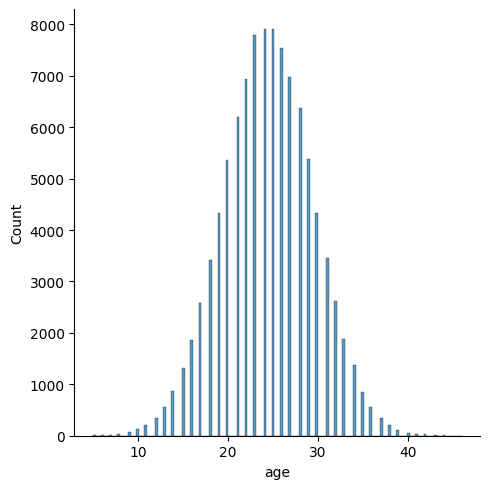

In [ ]:
import seaborn as sns

sns.displot(users_df['age'])

In [14]:
users_df

,user_id,age,gender,country,signup_date,subscription_type
0,1,16,Female,France,2022-12-17,Premium
1,2,26,Female,Norway,2022-01-22,Basic
2,3,30,Male,Greece,2022-10-27,Free
3,4,23,Male,Denmark,2020-07-16,Free
4,5,29,Female,Switzerland,2021-11-03,Free
...,...,...,...,...,...,...
99995,99996,18,Male,Sweden,2022-04-20,Free
99996,99997,23,Female,Italy,2022-02-20,Free
99997,99998,15,Female,Austria,2021-05-20,Basic
99998,99999,27,Female,Italy,2022-08-30,Free


In [15]:
revenue_df.groupby('revenue_type')['revenue_amount'].mean()

revenue_type
Advertisement      16.474741
In-app Purchase    16.566846
Subscription       16.081782
Name: revenue_amount, dtype: float64

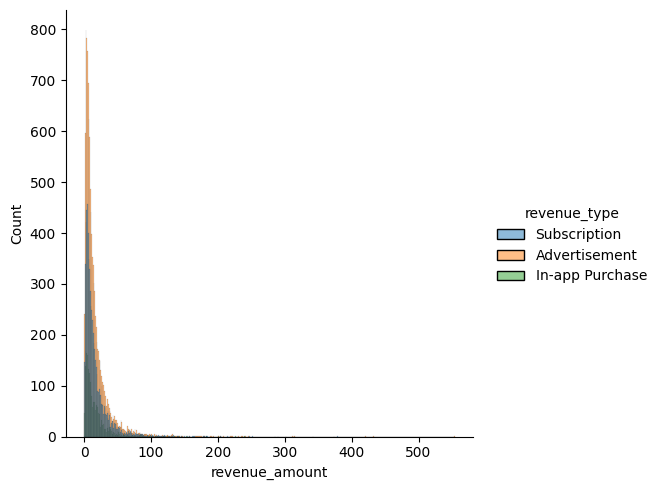

In [ ]:
sns.displot(data=revenue_df,  x='revenue_amount', hue='revenue_type')

In [ ]:
interactions_df

,user_id,content_id,interaction_type,interaction_timestamp
0,74562,1757,Added to Playlist,2021-11-27 09:39:19
1,70825,4201,Shared,2022-01-12 15:24:30
2,70825,2462,Played,2022-04-02 17:35:56
3,33717,3924,Shared,2022-03-09 04:58:30
4,774,4916,Added to Playlist,2023-02-01 09:36:43
...,...,...,...,...
49995,45173,3842,Disliked,2022-12-25 08:07:21
49996,87398,223,Liked,2021-10-06 19:04:27
49997,27435,3923,Played,2022-05-27 08:12:20
49998,55199,3615,Liked,2021-05-22 23:55:56


In [ ]:
content_df

,content_id,content_type,genre,release_year,duration_minutes,average_user_rating
0,1,TV Show,Western,2013,190,2.9
1,2,Movie,Sci-Fi,2003,72,2.8
2,3,Movie,Drama,2012,140,3.5
3,4,TV Show,Horror,2012,175,4.5
4,5,TV Show,Adventure,2016,114,1.3
...,...,...,...,...,...,...
4995,4996,Movie,Romance,1998,148,1.1
4996,4997,Movie,Crime,1994,170,4.9
4997,4998,Movie,Fantasy,1996,78,1.2
4998,4999,Movie,Documentary,1998,194,1.6


In [ ]:
ab_test_interactions_df

,user_id,content_id,group,interaction_type,interaction_timestamp
0,70595,344,Test,Played,2022-01-12 18:27:39
1,51701,2845,Test,Liked,2023-03-24 12:19:04
2,55901,1664,Control,Disliked,2023-02-28 14:18:51
3,81892,247,Test,Played,2022-09-06 14:07:34
4,95780,2031,Control,Liked,2022-09-26 02:26:15
...,...,...,...,...,...
9995,48700,2418,Control,Played,2021-09-25 18:55:25
9996,33016,2687,Control,Played,2022-11-17 22:35:31
9997,84133,424,Control,Played,2022-02-25 10:06:23
9998,48486,2523,Control,Disliked,2020-11-11 06:02:46
